In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
df = pd.read_csv('processed_data.csv')
df.head()

,loan_status,issue_d,addr_state,annual_inc,dti,emp_length,home_ownership,verification_status,loan_amnt,term,...,revol_bal,revol_util,pub_rec,pub_rec_bankruptcies,mort_acc,inq_last_6mths,target,credit_hist_len,unemployment_rate,delinq_rate
0,Fully Paid,2015-12-01,PA,55000.0,5.91,10,MORTGAGE,Not Verified,3600.0,36 months,...,2765.0,29.7,0.0,0.0,1.0,1.0,0,12.334018,5.0,2.01
1,Fully Paid,2015-12-01,SD,65000.0,16.06,10,MORTGAGE,Not Verified,24700.0,36 months,...,21470.0,19.2,0.0,0.0,4.0,4.0,0,16.000000,5.0,2.01
2,Fully Paid,2015-12-01,IL,63000.0,10.78,10,MORTGAGE,Not Verified,20000.0,60 months,...,7869.0,56.2,0.0,0.0,5.0,0.0,0,15.331964,5.0,2.01
3,Fully Paid,2015-12-01,PA,104433.0,25.37,3,MORTGAGE,Source Verified,10400.0,60 months,...,21929.0,64.5,0.0,0.0,6.0,3.0,0,17.500342,5.0,2.01
4,Fully Paid,2015-12-01,GA,34000.0,10.20,4,RENT,Source Verified,11950.0,36 months,...,8822.0,68.4,0.0,0.0,0.0,0.0,0,28.167009,5.0,2.01


In [3]:
print(df['target'].value_counts())

target
0    1076750
1     268559
Name: count, dtype: int64


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\mshri\AppData\Local\Temp\ipykernel_21148\3402243714.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='grade', y='target', data=def_rate_by_grade, palette='Reds')


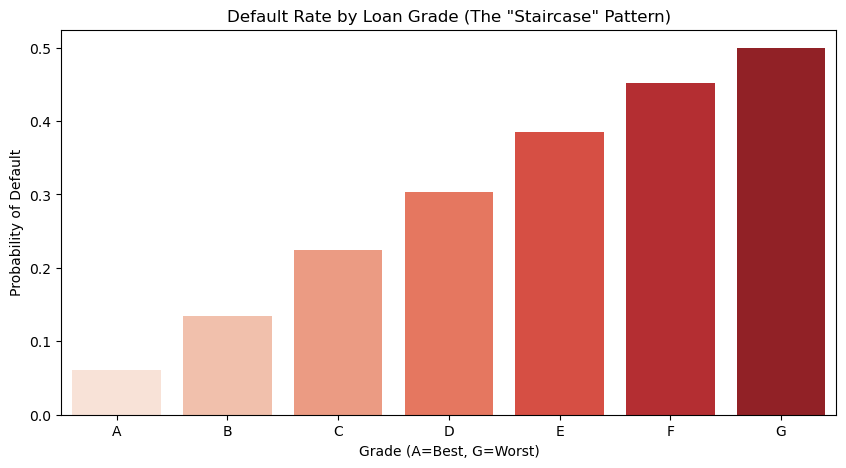

In [5]:
def_rate_by_grade = df.groupby('grade')['target'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='grade', y='target', data=def_rate_by_grade, palette='Reds')
plt.title('Default Rate by Loan Grade (The "Staircase" Pattern)')
plt.ylabel('Probability of Default')
plt.xlabel('Grade (A=Best, G=Worst)')
plt.show()

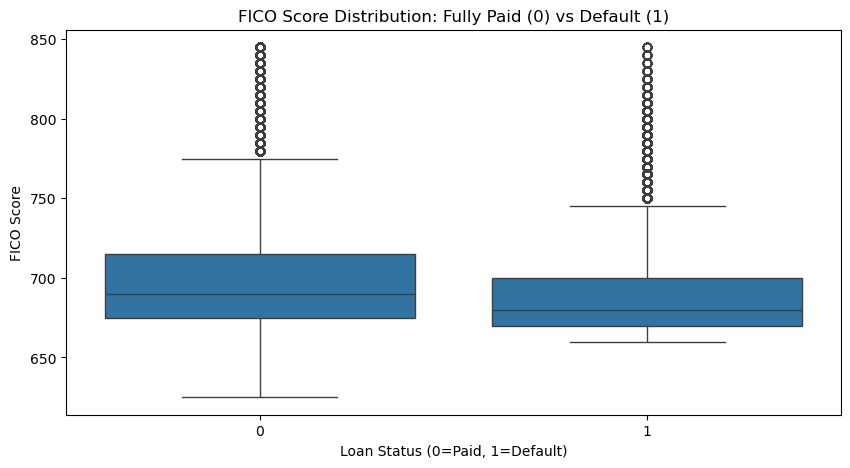

In [6]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='target', y='fico_range_low', data=df)
plt.title('FICO Score Distribution: Fully Paid (0) vs Default (1)')
plt.xlabel('Loan Status (0=Paid, 1=Default)')
plt.ylabel('FICO Score')
plt.show()

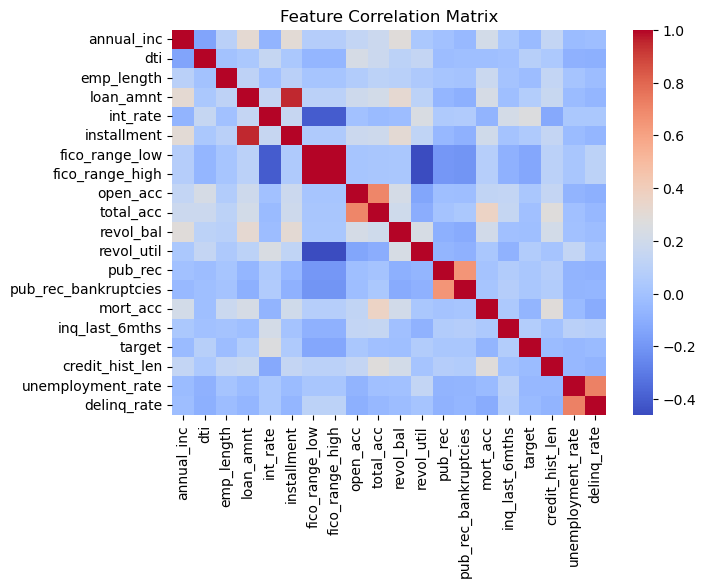

In [7]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [9]:
drop_cols = [
    'installment',
    'fico_range_high',
    'fico_range_low',
    'issue_d',
    'loan_status',
    'int_rate',
    'grade',
]

df_train = df.drop(columns=drop_cols)
print(f"Shape after dropping: {df_train.shape}")
print(f"Remaining columns: {df_train.columns.tolist()}")

Shape after dropping: (1345309, 22)
Remaining columns: ['addr_state', 'annual_inc', 'dti', 'emp_length', 'home_ownership', 'verification_status', 'loan_amnt', 'term', 'purpose', 'application_type', 'open_acc', 'total_acc', 'revol_bal', 'revol_util', 'pub_rec', 'pub_rec_bankruptcies', 'mort_acc', 'inq_last_6mths', 'target', 'credit_hist_len', 'unemployment_rate', 'delinq_rate']


In [10]:
df_train = pd.get_dummies(df_train, drop_first=True)
X = df_train.drop(columns=['target'])
y = df_train['target']

print(f"Feature count: {X.shape[1]}")
print(f"Class distribution:\n{y.value_counts(normalize=True).round(4)}")


Feature count: 87
Class distribution:
target
0    0.8004
1    0.1996
Name: proportion, dtype: float64


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1 
)
model.fit(X_train_scaled, y_train)

y_prob = model.predict_proba(X_test_scaled)[:, 1]
y_pred = model.predict(X_test_scaled)

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

ROC-AUC Score: 0.6898


In [15]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm,
    index=['Actual: No Default', 'Actual: Default'],
    columns=['Pred: No Default', 'Pred: Default']
))

              precision    recall  f1-score   support

           0       0.87      0.65      0.75    215350
           1       0.31      0.63      0.41     53712

    accuracy                           0.64    269062
   macro avg       0.59      0.64      0.58    269062
weighted avg       0.76      0.64      0.68    269062

                    Pred: No Default  Pred: Default
Actual: No Default            139811          75539
Actual: Default                20054          33658


In [14]:
coeffs = pd.DataFrame({
    'Feature': X.columns,
    'Weight': model.coef_[0]
}).sort_values(by='Weight', ascending=False)

print(" Risk Drivers (positive = higher default risk)")
print(coeffs.head(10).to_string())

print("\n Protective Factors (negative = lower default risk)")
print(coeffs.tail(10).to_string())

 Risk Drivers (positive = higher default risk)
                                Feature    Weight
72                      term_ 60 months  0.383623
7                            revol_util  0.207225
1                                   dti  0.201779
11                       inq_last_6mths  0.193046
71         verification_status_Verified  0.157951
4                              open_acc  0.131045
3                             loan_amnt  0.120531
70  verification_status_Source Verified  0.115355
83               purpose_small_business  0.084818
69                  home_ownership_RENT  0.081507

 Protective Factors (negative = lower default risk)
                    Feature    Weight
61            addr_state_WA -0.041415
51            addr_state_OR -0.042035
19            addr_state_CO -0.050033
2                emp_length -0.056491
65  home_ownership_MORTGAGE -0.080676
5                 total_acc -0.102454
10                 mort_acc -0.104712
6                 revol_bal -0.120609
0       

In [18]:
import joblib

joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns.tolist(), 'model_columns.pkl')


['model_columns.pkl']